# This notebook will generate the Bias based metrices results

In [ ]:
# model choices include 'bert','bert_supervised','birnn','cnngru','birnn_att','birnn_scrat'
# attention lambda for bert_supervised is 0.001 and birnn_scrat is 100
#python testing_for_bias.py <model> <att_lambda>
!python testing_for_bias.py bert_supervised 0.001

##  The bias score calculation is based on the work by Borkan et al. (2019)
### 1. Nuanced Metrics for Measuring Unintended Biaswith Real Data for Text Classification [https://arxiv.org/abs/1903.04561]
### 2. Kaggle competition: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation


In [1]:
from collections import Counter,defaultdict
from tqdm.notebook import tqdm
import json
import numpy as np

In [2]:
# get_annotated_data method is used to load the dataset
from Preprocess.dataCollect import get_annotated_data  

/home/saha/anaconda3/envs/explain_hate/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/home/saha/anaconda3/envs/explain_hate/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...


### Load the dataset. For bias calculation, we will need to group hatespeech and offensive into one class (toxic) and normal as another class (non-toxic)

In [3]:
dict_data_folder={
      '2':{'data_file':'Data/dataset.json','class_label':'Data/classes_two.npy'},
      '3':{'data_file':'Data/dataset.json','class_label':'Data/classes.npy'}
}

params = {}

# We need to load the dataset with the labels as 'toxic' and 'non-toxic'. 
# We consider hatespeech and offensive as toxic and normal as non-toxic.
params['num_classes']=2  
params['data_file']=dict_data_folder[str(params['num_classes'])]['data_file']
params['class_names']=dict_data_folder[str(params['num_classes'])]['class_label']

data_all_labelled=get_annotated_data(params)

In [4]:
data_all_labelled

,post_id,text,annotatorid1,target1,label1,annotatorid2,target2,label2,annotatorid3,target3,label3,rationales,final_label
0,1179055004553900032_twitter,"[i, dont, think, im, getting, my, baby, them, ...",1,[None],normal,2,[None],normal,3,[None],normal,[],non-toxic
1,1179063826874032128_twitter,"[we, cannot, continue, calling, ourselves, fem...",1,[None],normal,2,[None],normal,3,[None],normal,[],non-toxic
2,1178793830532956161_twitter,"[nawt, yall, niggers, ignoring, me]",4,[African],normal,2,[None],normal,3,[African],hatespeech,[],non-toxic
3,1179088797964763136_twitter,"[<user>, i, am, bit, confused, coz, chinese, p...",1,[Asian],hatespeech,4,[Asian],offensive,3,[Asian],hatespeech,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",toxic
4,1179085312976445440_twitter,"[this, bitch, in, whataburger, eating, a, burg...",4,"[Caucasian, Women]",hatespeech,2,"[Women, Caucasian]",hatespeech,3,"[Women, Caucasian]",offensive,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",toxic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20143,9989999_gab,"[if, ur, still, on, twitter, tell, carlton, i,...",217,"[Men, Women, Other]",offensive,199,[None],offensive,215,[None],normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,...",toxic
20144,9990225_gab,"[when, i, first, got, on, here, and, said, i, ...",220,[African],offensive,223,"[African, Other]",offensive,231,[None],normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,...",toxic
20145,9991681_gab,"[was, macht, der, moslem, wenn, der, zion, geg...",206,[Islam],offensive,203,[Other],normal,211,[None],normal,[],non-toxic
20146,9992513_gab,"[it, is, awful, look, at, world, demographics,...",209,[Hispanic],hatespeech,253,[Asian],hatespeech,222,[Asian],offensive,"[[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,...",toxic


### This function is used to extract the target community based on majority voting. If at least 2 annoatators (out of 3) have selected a community, then we consider it.

In [5]:
def generate_target_information(dataset):
    final_target_output = defaultdict(list)
    all_communities_selected = []
    
    for each in dataset.iterrows(): 
        # All the target communities tagged for this post
        all_targets = each[1]['target1']+each[1]['target2']+each[1]['target3']  
        community_dict = dict(Counter(all_targets))
        
        # Select only those communities which are present more than once.
        for key in community_dict:
            if community_dict[key]>1:  
                final_target_output[each[1]['post_id']].append(key)
                all_communities_selected.append(key)
        
        # If no community is selected based on majority voting then we don't select any community
        if each[1]['post_id'] not in final_target_output:
            final_target_output[each[1]['post_id']].append('None')
            all_communities_selected.append(key)

    return final_target_output, all_communities_selected

In [6]:
target_information, all_communities_selected = generate_target_information(data_all_labelled)

In [7]:
community_count_dict = Counter(all_communities_selected)

# We remove None and Other from dictionary
community_count_dict.pop('None')
community_count_dict.pop('Other')

# For the bias calculation, we are considering the top 10 communites based on their count
list_selected_community = [community for community, value in community_count_dict.most_common(10)]
list_selected_community

['African',
 'Islam',
 'Jewish',
 'Homosexual',
 'Women',
 'Refugee',
 'Arab',
 'Caucasian',
 'Asian',
 'Hispanic']

In [8]:
# Based on the top 10 communities, we filter the target_information
# This will remove the other communities from the calculation

final_target_information ={}
for each in target_information:
    temp = list(set(target_information[each])&set(list_selected_community))
    if len(temp) == 0:
        final_target_information[each] = None
    else:
        final_target_information[each] = temp

In [9]:
# Add a new column 'final_target_category' which will contain the selected target community names
data_all_labelled['final_target_category'] = data_all_labelled['post_id'].map(final_target_information) 

In [10]:
# The post_id_divisions file stores the train, val, test split ids. We select only the test ids.
postpost_id_divisions_path = './Data/post_id_divisions.json'

with open(postpost_id_divisions_path, 'r') as fp:
    post_id_dict=json.load(fp)

data_all_labelled_bias = data_all_labelled[data_all_labelled['post_id'].isin(post_id_dict['test'])]
data_all_labelled_bias

,post_id,text,annotatorid1,target1,label1,annotatorid2,target2,label2,annotatorid3,target3,label3,rationales,final_label,final_target_category
0,1179055004553900032_twitter,"[i, dont, think, im, getting, my, baby, them, ...",1,[None],normal,2,[None],normal,3,[None],normal,[],non-toxic,None
5,13851720_gab,"[laura, loomer, raped, me, while, screaming, a...",1,[Jewish],hatespeech,2,[Jewish],hatespeech,3,[Jewish],hatespeech,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,...",toxic,[Jewish]
17,1178818409812746240_twitter,"[<user>, what, did, the, old, lady, do, was, s...",9,[None],normal,10,[None],normal,4,[None],normal,[],non-toxic,None
25,19346774_gab,"[as, much, as, i, appreciate, a, format, of, o...",9,[None],normal,13,[None],normal,4,[Hispanic],offensive,[],non-toxic,None
36,1165819983701643266_twitter,"[sex, be, so, good, a, bitch, be, slow, stroki...",4,[Women],offensive,7,[Women],offensive,16,[None],normal,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, ...",toxic,[Women]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20105,9773208_gab,"[it, always, women, trying, this, shit, like, ...",200,[Women],hatespeech,202,[Women],offensive,203,[Women],offensive,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",toxic,[Women]
20109,9802943_gab,"[because, women, would, never, lie, about, bei...",228,[Women],offensive,222,[Women],offensive,209,[Women],normal,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",toxic,[Women]
20117,9826963_gab,"[how, is, all, that, awesome, muslim, diversit...",228,[Islam],offensive,222,[Islam],offensive,209,[Islam],offensive,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",toxic,[Islam]
20128,9867117_gab,"[well, my, dear, lgbtq, brothers, and, sisters...",207,"[Islam, Other]",offensive,223,[Islam],hatespeech,231,[Islam],hatespeech,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",toxic,[Islam]


In [11]:
from sklearn.metrics import roc_auc_score

# The names of the files which will contain the bias output for each model
bias_score_file_mapping={
    'CNN-GRU':'bestModel_cnn_gru_bias.json',
    'BiRNN':'bestModel_birnn_bias.json',
    'BiRNN-Attn':'bestModel_birnnatt_bias.json',
    'BiRNN-HateXplain':'bestModel_birnnscrat_bias.json',
    'BERT': 'bestModel_bert_base_uncased_Attn_train_FALSE_bias.json',
    'BERT-HateXplain': 'bestModel_bert_base_uncased_Attn_train_TRUE_bias.json'
}

# The parent folder path of the bias output files
parent_path = './explanations_dicts/'

# The bias methods that will be considered
method_list = ['subgroup', 'bpsn', 'bnsp']

community_list = list(list_selected_community)


In [12]:
# This function is used to convert the classification into a [0-1] score 
# with a value of 0 meaning non-toxic and 1 meaning toxic
def convert_to_score(label_name, label_dict):
    if label_name=='non-toxic':
        return 1-label_dict[label_name]
    else:
        return label_dict[label_name]

In [13]:
# Function to divide the ids into postive or class class based on the method.
def bias_evaluation_metric(dataset, method, community):
    positive_ids = []
    negative_ids = []
    if method=='subgroup':
        for eachrow in dataset.iterrows():
            if eachrow[1]['final_target_category'] == None:
                continue
            if community in eachrow[1]['final_target_category']:
                if eachrow[1]['final_label'] =='non-toxic':
                    negative_ids.append(eachrow[1]['post_id'])
                else:
                    positive_ids.append(eachrow[1]['post_id'])
            else:
                pass
    elif method=='bpsn':
        for eachrow in dataset.iterrows():
            if eachrow[1]['final_target_category'] == None:
                continue
            if community in eachrow[1]['final_target_category']:
#                 print(eachrow[1]['final_label'])
                if eachrow[1]['final_label'] =='non-toxic':
                    negative_ids.append(eachrow[1]['post_id'])
                else:
                    pass
            else:
                if eachrow[1]['final_label'] !='non-toxic':
                    positive_ids.append(eachrow[1]['post_id'])
                else:
                    pass
    elif method=='bnsp':
        for eachrow in dataset.iterrows():
            if eachrow[1]['final_target_category'] == None:
                continue
            if community in eachrow[1]['final_target_category']:
                if eachrow[1]['final_label'] !='non-toxic':
                    positive_ids.append(eachrow[1]['post_id'])
                else:
                    pass
            else:
                if eachrow[1]['final_label'] =='non-toxic':
                    negative_ids.append(eachrow[1]['post_id'])
                else:
                    pass
    else:
        print('Incorrect option selected!!!')
                
    return {'positiveID':positive_ids, 'negativeID':negative_ids}

In [14]:
final_bias_dictionary = defaultdict(lambda: defaultdict(dict))

# We load each of the model bias output file and compute the bias score using each method for all the community
for each_model in tqdm(bias_score_file_mapping):
    total_data ={}
    with open(parent_path+bias_score_file_mapping[each_model]) as fp:
        for line in fp:
            data = json.loads(line)
            total_data[data['annotation_id']] = data
    for each_method in method_list:
        for each_community in community_list:
            community_data = bias_evaluation_metric(data_all_labelled_bias, each_method, each_community)
            truth_values = []
            prediction_values = []


            label_to_value = {'toxic':1.0, 'non-toxic':0.0}
            for each in community_data['positiveID']:
                truth_values.append(label_to_value[total_data[each]['ground_truth']])
                prediction_values.append(convert_to_score(total_data[each]['classification'], total_data[each]['classification_scores']))

            for each in community_data['negativeID']:
                truth_values.append(label_to_value[total_data[each]['ground_truth']])
                prediction_values.append(convert_to_score(total_data[each]['classification'], total_data[each]['classification_scores']))

            roc_output_value = roc_auc_score(truth_values, prediction_values)
            final_bias_dictionary[each_model][each_method][each_community] = roc_output_value

In [15]:
%precision 4

'%.4f'

### To combine the per-community Bias AUCs into one overall measure, we calculate their generalized mean as defined below:



\begin{equation*}
M _ { p } \left( m _ { s } \right) = \left( \frac { 1 } { N } \sum _ { s = 1 } ^ { N } m _ { s } ^ { p } \right) ^ { \frac { 1 } { p } }
\end{equation*}
where, $M_p$  = the $p^\textrm{th}$ power-mean function, $m_s$ = the bias metric $m$ calculated for subgroup $s$ and
$N$ = number of identity subgroups (10). We use $p=-5$ as was also done in the kaggle competition.


In [16]:
# To combine the per-identity Bias AUCs into one overall measure, we calculate their generalized mean as defined below:
power_value = -5
num_communities = len(community_list)

for each_model in final_bias_dictionary:
    for each_method in final_bias_dictionary[each_model]:
        temp_value =[]
        for each_community in final_bias_dictionary[each_model][each_method]:
            temp_value.append(pow(final_bias_dictionary[each_model][each_method][each_community], power_value))
        print(each_model, each_method, pow(np.sum(temp_value)/num_communities, 1/power_value))

CNN-GRU subgroup 0.6466978879207836
CNN-GRU bpsn 0.5693649805755786
CNN-GRU bnsp 0.6724306506355714
BiRNN subgroup 0.6810314474607603
BiRNN bpsn 0.6050351375344387
BiRNN bnsp 0.6805879961427638
BiRNN-Attn subgroup 0.6663809312442344
BiRNN-Attn bpsn 0.6181856498477524
BiRNN-Attn bnsp 0.649972808754877
BiRNN-HateXplain subgroup 0.6025971308391711
BiRNN-HateXplain bpsn 0.48742670844544606
BiRNN-HateXplain bnsp 0.6989208969036491
BERT subgroup 0.7567999065169655
BERT bpsn 0.6768417449576831
BERT bnsp 0.7639961576439063
BERT-HateXplain subgroup 0.7801852254796021
BERT-HateXplain bpsn 0.6994490257746223
BERT-HateXplain bnsp 0.7803493711295375


### To plot the score for individual communities

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [18]:
tuple_community = []
for each_model in final_bias_dictionary:
    # Select the metric which you want to view. Possible values are subgroup, bpsn, bnsp
    each_method = 'bnsp' 
    
    for each_community in final_bias_dictionary[each_model][each_method]:
        tuple_community.append((each_model, each_community, final_bias_dictionary[each_model][each_method][each_community]))

In [19]:
df_community_score = pd.DataFrame(tuple_community, columns=['Model', 'Community', 'AUCROC'])

bnsp


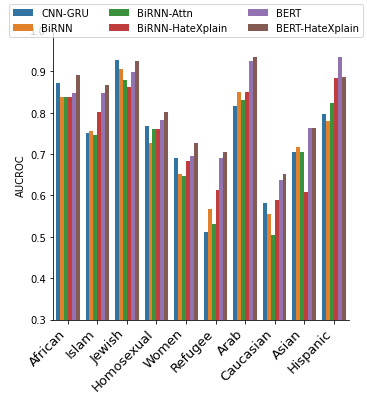

In [20]:
ax = sns.catplot(x="Community", y="AUCROC", hue="Model",
             data=df_community_score,
                 legend=False,
                kind="bar");
ax.set(ylim=(0.3, 1.0))
ax.set_xticklabels(rotation=45, size=13, horizontalalignment='right')

# sns.set(font_scale = 0.1)



handles = ax._legend_data.values()
labels = ax._legend_data.keys()

ax.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=3)
ax.fig.subplots_adjust(top=0.92)

ax.set(xlabel="")  

print(each_method)
# plt.savefig('bias-'+each_method+'.pdf', dpi=300, transparent=True, bbox_inches='tight')